# Two-Tower Incremental Fast Training

This notebook is optimized for faster training and **does not delete existing vectors**.
It reuses vectors from `two_tower_vecdb.sqlite` when present, initializes only missing IDs, and upserts updates.

In [106]:
from __future__ import annotations

import json
import os
import random
import re
import sqlite3
import time
from concurrent.futures import FIRST_COMPLETED, ThreadPoolExecutor, wait
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
from dotenv import load_dotenv
from openai import OpenAI


In [107]:
# ---------- Config ----------
SEED = 7
EMBED_DIM = 16
LLM_MODEL = 'gpt-5-nano'
MAX_WORKERS = 24
LLM_MAX_OUTPUT_TOKENS = 24
LLM_RETRIES = 1
LLM_RETRY_BACKOFF_SEC = 0.15
LLM_TIMEOUT_SEC = 20

PULL_LR = 0.14
PUSH_LR = 0.10

ROUNDS = 1

JOB_CLUSTER_ITERS = 100
USER_CLUSTER_ITERS = 500
USER_TO_JOB_ITERS = 1000
JOB_TO_USER_ITERS = 500
SAVE_EVERY = 100

DB_CANDIDATES = [
    Path('../hireup.db'),
    Path('hireup.db'),
    Path('../backend/hireup.db'),
    Path('backend/hireup.db'),
]
VECDB_PATH = Path('two_tower_vecdb.sqlite')

random.seed(SEED)
np.random.seed(SEED)

load_dotenv(Path('../.env'))
load_dotenv(Path('.env'))
api_key = os.getenv('OPENAI_API_KEY', '').strip()
if not api_key:
    raise RuntimeError('OPENAI_API_KEY not found. Put it in .env')

client = OpenAI(api_key=api_key)

def resolve_main_db() -> Path:
    existing = [p for p in DB_CANDIDATES if p.exists()]
    if not existing:
        raise FileNotFoundError(f'No DB found. Checked: {[str(p) for p in DB_CANDIDATES]}')

    for p in existing:
        with sqlite3.connect(p) as conn:
            tables = {r[0] for r in conn.execute("SELECT name FROM sqlite_master WHERE type='table'")}
            if 'jobs' in tables and 'users' in tables:
                return p
    return existing[0]

if ROUNDS <= 0:
    raise ValueError('ROUNDS must be >= 1')

MAIN_DB_PATH = resolve_main_db()
print('Using source DB:', MAIN_DB_PATH.resolve())
print('Using vecdb:', VECDB_PATH.resolve())

Using source DB: /Users/hjiang/Documents/HireUp/hireup.db
Using vecdb: /Users/hjiang/Documents/HireUp/two-tower/two_tower_vecdb.sqlite


In [108]:
# ---------- Load users/jobs ----------
with sqlite3.connect(MAIN_DB_PATH) as conn:
    conn.row_factory = sqlite3.Row
    jobs = [dict(r) for r in conn.execute(
        """
        SELECT id, company_id, title, description, skills, location, salary_range, status
        FROM jobs
        WHERE COALESCE(TRIM(description), '') <> ''
        """
    ).fetchall()]
    users = [dict(r) for r in conn.execute(
        """
        SELECT id, email, name, resume_text, objective, career_objective, interests
        FROM users
        WHERE COALESCE(TRIM(resume_text), '') <> ''
        """
    ).fetchall()]

if len(jobs) < 5:
    raise RuntimeError(f'Need >= 5 jobs; found {len(jobs)}')
if len(users) < 5:
    raise RuntimeError(f'Need >= 5 users; found {len(users)}')

job_ids = [j['id'] for j in jobs]
user_ids = [u['id'] for u in users]
jobs_by_id = {j['id']: j for j in jobs}
users_by_id = {u['id']: u for u in users}

print(f'Loaded {len(job_ids)} jobs and {len(user_ids)} users')

Loaded 64 jobs and 1479 users


In [109]:
# ---------- VecDB helpers (incremental / no delete) ----------
def normalize(v: np.ndarray) -> np.ndarray:
    n = float(np.linalg.norm(v))
    if n <= 1e-12:
        w = np.random.normal(size=v.shape[0]).astype(np.float32)
        return w / np.linalg.norm(w)
    return (v / n).astype(np.float32)

def rand_unit(dim: int) -> np.ndarray:
    return normalize(np.random.normal(size=dim).astype(np.float32))

def compact_job_metadata(j: dict) -> dict:
    return {
        'company_id': j.get('company_id'),
        'title': j.get('title'),
        'description': (j.get('description') or '')[:2000],
        'skills': j.get('skills'),
        'location': j.get('location'),
        'salary_range': j.get('salary_range'),
        'status': j.get('status'),
    }

def compact_user_metadata(u: dict) -> dict:
    return {
        'email': u.get('email'),
        'name': u.get('name'),
        'resume_text': (u.get('resume_text') or '')[:4000],
        'objective': u.get('objective'),
        'career_objective': u.get('career_objective'),
        'interests': u.get('interests'),
    }

job_meta = {jid: compact_job_metadata(jobs_by_id[jid]) for jid in job_ids}
user_meta = {uid: compact_user_metadata(users_by_id[uid]) for uid in user_ids}

def init_vecdb(path: Path) -> None:
    with sqlite3.connect(path) as conn:
        conn.execute(
            """
            CREATE TABLE IF NOT EXISTS job_vectors (
                id TEXT PRIMARY KEY,
                vector_json TEXT NOT NULL,
                metadata_json TEXT NOT NULL,
                updated_at TEXT DEFAULT (datetime('now'))
            )
            """
        )
        conn.execute(
            """
            CREATE TABLE IF NOT EXISTS user_vectors (
                id TEXT PRIMARY KEY,
                vector_json TEXT NOT NULL,
                metadata_json TEXT NOT NULL,
                updated_at TEXT DEFAULT (datetime('now'))
            )
            """
        )

def load_existing_vectors(path: Path, table: str) -> Dict[str, np.ndarray]:
    out: Dict[str, np.ndarray] = {}
    if not path.exists():
        return out

    with sqlite3.connect(path) as conn:
        conn.row_factory = sqlite3.Row
        tables = {r['name'] for r in conn.execute("SELECT name FROM sqlite_master WHERE type='table'")}
        if table not in tables:
            return out

        rows = conn.execute(f"SELECT id, vector_json FROM {table}").fetchall()
        for r in rows:
            try:
                vec = np.array(json.loads(r['vector_json']), dtype=np.float32)
                if vec.shape[0] != EMBED_DIM:
                    continue
                out[r['id']] = normalize(vec)
            except Exception:
                continue
    return out

def persist_upsert(path: Path) -> None:
    with sqlite3.connect(path) as conn:
        conn.executemany(
            """
            INSERT INTO job_vectors (id, vector_json, metadata_json, updated_at)
            VALUES (?, ?, ?, datetime('now'))
            ON CONFLICT(id) DO UPDATE SET
                vector_json = excluded.vector_json,
                metadata_json = excluded.metadata_json,
                updated_at = datetime('now')
            """,
            [(jid, json.dumps(job_vecs[jid].tolist()), json.dumps(job_meta[jid])) for jid in job_ids],
        )
        conn.executemany(
            """
            INSERT INTO user_vectors (id, vector_json, metadata_json, updated_at)
            VALUES (?, ?, ?, datetime('now'))
            ON CONFLICT(id) DO UPDATE SET
                vector_json = excluded.vector_json,
                metadata_json = excluded.metadata_json,
                updated_at = datetime('now')
            """,
            [(uid, json.dumps(user_vecs[uid].tolist()), json.dumps(user_meta[uid])) for uid in user_ids],
        )

init_vecdb(VECDB_PATH)
existing_job_vecs = load_existing_vectors(VECDB_PATH, 'job_vectors')
existing_user_vecs = load_existing_vectors(VECDB_PATH, 'user_vectors')

job_vecs = {jid: existing_job_vecs.get(jid, rand_unit(EMBED_DIM)) for jid in job_ids}
user_vecs = {uid: existing_user_vecs.get(uid, rand_unit(EMBED_DIM)) for uid in user_ids}

persist_upsert(VECDB_PATH)
print(f'Reused {sum(1 for j in job_ids if j in existing_job_vecs)} existing job vectors')
print(f'Reused {sum(1 for u in user_ids if u in existing_user_vecs)} existing user vectors')

Reused 0 existing job vectors
Reused 0 existing user vectors


In [110]:
# ---------- LLM helpers ----------
def extract_json_object(text: str) -> dict:
    text = (text or '').strip()
    try:
        return json.loads(text)
    except Exception:
        pass

    m = re.search(r'\{.*\}', text, flags=re.S)
    if not m:
        raise ValueError(f'No JSON object in model output: {text[:200]}')
    return json.loads(m.group(0))

def llm_json(system_prompt: str, user_prompt: str, retries: int = LLM_RETRIES, fallback: dict | None = None) -> dict:
    last_err = None
    for attempt in range(retries):
        try:
            resp = client.responses.create(
                model=LLM_MODEL,
                input=[
                    {'role': 'system', 'content': system_prompt},
                    {'role': 'user', 'content': user_prompt},
                ],
                max_output_tokens=LLM_MAX_OUTPUT_TOKENS,
                timeout=LLM_TIMEOUT_SEC,
            )
            return extract_json_object(resp.output_text)
        except Exception as e:
            last_err = e
            time.sleep(LLM_RETRY_BACKOFF_SEC * (attempt + 1))

    if fallback is not None:
        return fallback
    raise RuntimeError(f'LLM call failed after retries: {last_err}')

def safe_pair(out: dict) -> Tuple[int, int]:
    pair = out.get('pair', [0, 1])
    if not isinstance(pair, list) or len(pair) != 2:
        return (0, 1)
    i = int(pair[0]) if str(pair[0]).lstrip('-').isdigit() else 0
    j = int(pair[1]) if str(pair[1]).lstrip('-').isdigit() else 1
    i = max(0, min(4, i))
    j = max(0, min(4, j))
    if i == j:
        j = (j + 1) % 5
    return (i, j)

def safe_winner(out: dict) -> int:
    w = out.get('winner', 0)
    if not str(w).lstrip('-').isdigit():
        return 0
    return max(0, min(4, int(w)))

def apply_pull(a: np.ndarray, b: np.ndarray, lr: float = PULL_LR) -> Tuple[np.ndarray, np.ndarray]:
    a0 = a.copy()
    b0 = b.copy()
    a1 = normalize((1.0 - lr) * a0 + lr * b0)
    b1 = normalize((1.0 - lr) * b0 + lr * a0)
    return a1, b1

def apply_push(anchor: np.ndarray, other: np.ndarray, lr: float = PUSH_LR) -> np.ndarray:
    return normalize(other - lr * anchor)


In [111]:
# ---------- Training tasks ----------
def step3_job_cluster_once(sample_ids: List[str]) -> Tuple[List[str], Tuple[int, int]]:
    payload = []
    for i, jid in enumerate(sample_ids):
        j = jobs_by_id[jid]
        payload.append({
            'i': i,
            'title': j.get('title'),
            'description': (j.get('description') or '')[:700],
            'skills': j.get('skills'),
        })

    system = 'You compare job posting similarity. Return only JSON.'
    user = (
        'Pick the TWO most similar jobs. Output exactly: {"pair":[i,j]} where i,j are distinct in [0,4].\n'
        f"Jobs:{json.dumps(payload, ensure_ascii=True, separators=(',', ':'))}"
    )

    out = llm_json(system, user, fallback={'pair': [0, 1]})
    i, j = safe_pair(out)
    return sample_ids, (i, j)


def step3b_job_worst_once(sample_ids: List[str]) -> Tuple[List[str], int]:
    payload = []
    for i, jid in enumerate(sample_ids):
        j = jobs_by_id[jid]
        payload.append({
            'i': i,
            'title': j.get('title'),
            'description': (j.get('description') or '')[:700],
            'skills': j.get('skills'),
        })

    system = 'You compare job posting fit. Return only JSON.'
    user = (
        'Pick the ONE worst-fit / least similar job among these options. '
        'Output exactly: {"winner":i} where i in [0,4].\n'
        f"Jobs:{json.dumps(payload, ensure_ascii=True, separators=(',', ':'))}"
    )

    out = llm_json(system, user, fallback={'winner': 0})
    return sample_ids, safe_winner(out)


def step4_user_cluster_once(sample_ids: List[str]) -> Tuple[List[str], Tuple[int, int]]:
    payload = []
    for i, uid in enumerate(sample_ids):
        u = users_by_id[uid]
        payload.append({
            'i': i,
            'resume_text': (u.get('resume_text') or '')[:1000],
        })

    system = 'You compare candidate similarity. Return only JSON.'
    user = (
        'Pick the TWO most similar users. Output exactly: {"pair":[i,j]} where i,j are distinct in [0,4].\n'
        f"Users:{json.dumps(payload, ensure_ascii=True, separators=(',', ':'))}"
    )

    out = llm_json(system, user, fallback={'pair': [0, 1]})
    i, j = safe_pair(out)
    return sample_ids, (i, j)


def step4b_user_worst_once(sample_ids: List[str]) -> Tuple[List[str], int]:
    payload = []
    for i, uid in enumerate(sample_ids):
        u = users_by_id[uid]
        payload.append({
            'i': i,
            'resume_text': (u.get('resume_text') or '')[:1000],
        })

    system = 'You compare candidate fit. Return only JSON.'
    user = (
        'Pick the ONE worst-fit / least similar user among these options. '
        'Output exactly: {"winner":i} where i in [0,4].\n'
        f"Users:{json.dumps(payload, ensure_ascii=True, separators=(',', ':'))}"
    )

    out = llm_json(system, user, fallback={'winner': 0})
    return sample_ids, safe_winner(out)


def step5_user_to_jobs_once(uid: str, sample_job_ids: List[str]) -> Tuple[str, List[str], int]:
    u = users_by_id[uid]
    payload = []
    for i, jid in enumerate(sample_job_ids):
        j = jobs_by_id[jid]
        payload.append({
            'i': i,
            'title': j.get('title'),
            'description': (j.get('description') or '')[:700],
            'skills': j.get('skills'),
        })

    user_payload = {
        'resume_text': (u.get('resume_text') or '')[:1000],
    }

    system = 'You rank which job a user would most likely apply to. Return only JSON.'
    user = (
        'Output exactly: {"winner":i} where i in [0,4].\n'
        f"User:{json.dumps(user_payload, ensure_ascii=True, separators=(',', ':'))}\n"
        f"Jobs:{json.dumps(payload, ensure_ascii=True, separators=(',', ':'))}"
    )

    out = llm_json(system, user, fallback={'winner': 0})
    return uid, sample_job_ids, safe_winner(out)


def step5b_user_to_jobs_worst_once(uid: str, sample_job_ids: List[str]) -> Tuple[str, List[str], int]:
    u = users_by_id[uid]
    payload = []
    for i, jid in enumerate(sample_job_ids):
        j = jobs_by_id[jid]
        payload.append({
            'i': i,
            'title': j.get('title'),
            'description': (j.get('description') or '')[:700],
            'skills': j.get('skills'),
        })

    user_payload = {
        'resume_text': (u.get('resume_text') or '')[:1000],
    }

    system = 'You rank which job a user is least likely to apply to. Return only JSON.'
    user = (
        'Output exactly: {"winner":i} where i in [0,4], representing the WORST fit.\n'
        f"User:{json.dumps(user_payload, ensure_ascii=True, separators=(',', ':'))}\n"
        f"Jobs:{json.dumps(payload, ensure_ascii=True, separators=(',', ':'))}"
    )

    out = llm_json(system, user, fallback={'winner': 0})
    return uid, sample_job_ids, safe_winner(out)


def step6_job_to_users_once(jid: str, sample_user_ids: List[str]) -> Tuple[str, List[str], int]:
    j = jobs_by_id[jid]
    payload = []
    for i, uid in enumerate(sample_user_ids):
        u = users_by_id[uid]
        payload.append({
            'i': i,
            'resume_text': (u.get('resume_text') or '')[:1000],
        })

    job_payload = {
        'title': j.get('title'),
        'description': (j.get('description') or '')[:700],
        'skills': j.get('skills'),
    }

    system = 'You rank which user a job would most likely accept. Return only JSON.'
    user = (
        'Output exactly: {"winner":i} where i in [0,4].\n'
        f"Job:{json.dumps(job_payload, ensure_ascii=True, separators=(',', ':'))}\n"
        f"Users:{json.dumps(payload, ensure_ascii=True, separators=(',', ':'))}"
    )

    out = llm_json(system, user, fallback={'winner': 0})
    return jid, sample_user_ids, safe_winner(out)


def step6b_job_to_users_worst_once(jid: str, sample_user_ids: List[str]) -> Tuple[str, List[str], int]:
    j = jobs_by_id[jid]
    payload = []
    for i, uid in enumerate(sample_user_ids):
        u = users_by_id[uid]
        payload.append({
            'i': i,
            'resume_text': (u.get('resume_text') or '')[:1000],
        })

    job_payload = {
        'title': j.get('title'),
        'description': (j.get('description') or '')[:700],
        'skills': j.get('skills'),
    }

    system = 'You rank which user is the worst fit / least likely acceptance for the job. Return only JSON.'
    user = (
        'Output exactly: {"winner":i} where i in [0,4], representing the WORST fit.\n'
        f"Job:{json.dumps(job_payload, ensure_ascii=True, separators=(',', ':'))}\n"
        f"Users:{json.dumps(payload, ensure_ascii=True, separators=(',', ':'))}"
    )

    out = llm_json(system, user, fallback={'winner': 0})
    return jid, sample_user_ids, safe_winner(out)


def run_parallel(total_iters: int, make_task, apply_result, label: str) -> None:
    if total_iters <= 0:
        return

    done = 0
    failures = 0
    submitted = 0

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
        in_flight = set()
        initial = min(MAX_WORKERS, total_iters)
        for _ in range(initial):
            in_flight.add(ex.submit(make_task))
            submitted += 1

        while in_flight:
            finished, in_flight = wait(in_flight, return_when=FIRST_COMPLETED)

            for f in finished:
                try:
                    result = f.result()
                    apply_result(result)
                except Exception as e:
                    failures += 1
                    if failures <= 5 or failures % 20 == 0:
                        print(f'[{label}] task failed ({failures}): {e}')

                done += 1

                if submitted < total_iters:
                    in_flight.add(ex.submit(make_task))
                    submitted += 1

                if done % SAVE_EVERY == 0:
                    persist_upsert(VECDB_PATH)
                if done % 20 == 0 or done == total_iters:
                    print(f'[{label}] {done}/{total_iters} (failures={failures})')


def make_step3_task():
    return step3_job_cluster_once(random.sample(job_ids, 5))


def apply_step3_result(result):
    sample_ids, (i, j) = result
    a_id = sample_ids[i]
    b_id = sample_ids[j]
    va, vb = apply_pull(job_vecs[a_id], job_vecs[b_id])
    job_vecs[a_id], job_vecs[b_id] = va, vb


def make_step3b_task():
    return step3b_job_worst_once(random.sample(job_ids, 5))


def apply_step3b_result(result):
    sample_ids, worst_idx = result
    worst_id = sample_ids[worst_idx]
    others = [job_vecs[sample_ids[i]] for i in range(len(sample_ids)) if i != worst_idx]
    if not others:
        return
    anchor = normalize(np.mean(np.stack(others), axis=0))
    job_vecs[worst_id] = apply_push(anchor, job_vecs[worst_id])


def make_step4_task():
    return step4_user_cluster_once(random.sample(user_ids, 5))


def apply_step4_result(result):
    sample_ids, (i, j) = result
    a_id = sample_ids[i]
    b_id = sample_ids[j]
    va, vb = apply_pull(user_vecs[a_id], user_vecs[b_id])
    user_vecs[a_id], user_vecs[b_id] = va, vb


def make_step4b_task():
    return step4b_user_worst_once(random.sample(user_ids, 5))


def apply_step4b_result(result):
    sample_ids, worst_idx = result
    worst_id = sample_ids[worst_idx]
    others = [user_vecs[sample_ids[i]] for i in range(len(sample_ids)) if i != worst_idx]
    if not others:
        return
    anchor = normalize(np.mean(np.stack(others), axis=0))
    user_vecs[worst_id] = apply_push(anchor, user_vecs[worst_id])


def make_step5_task():
    uid = random.choice(user_ids)
    return step5_user_to_jobs_once(uid, random.sample(job_ids, 5))


def apply_step5_result(result):
    uid, sample_jobs, winner_idx = result
    win_jid = sample_jobs[winner_idx]
    uv, jv = apply_pull(user_vecs[uid], job_vecs[win_jid])
    user_vecs[uid], job_vecs[win_jid] = uv, jv


def make_step5b_task():
    uid = random.choice(user_ids)
    return step5b_user_to_jobs_worst_once(uid, random.sample(job_ids, 5))


def apply_step5b_result(result):
    uid, sample_jobs, worst_idx = result
    worst_jid = sample_jobs[worst_idx]
    job_vecs[worst_jid] = apply_push(user_vecs[uid], job_vecs[worst_jid])


def make_step6_task():
    jid = random.choice(job_ids)
    return step6_job_to_users_once(jid, random.sample(user_ids, 5))


def apply_step6_result(result):
    jid, sample_users, winner_idx = result
    win_uid = sample_users[winner_idx]
    jv, uv = apply_pull(job_vecs[jid], user_vecs[win_uid])
    job_vecs[jid], user_vecs[win_uid] = jv, uv


def make_step6b_task():
    jid = random.choice(job_ids)
    return step6b_job_to_users_worst_once(jid, random.sample(user_ids, 5))


def apply_step6b_result(result):
    jid, sample_users, worst_idx = result
    worst_uid = sample_users[worst_idx]
    user_vecs[worst_uid] = apply_push(job_vecs[jid], user_vecs[worst_uid])


In [112]:
ROUNDS = 10

# ---------- Run training (incremental) ----------
for r in range(ROUNDS):
    print(f'\n=== Round {r + 1}/{ROUNDS} ===')
    run_parallel(JOB_CLUSTER_ITERS, make_step3_task, apply_step3_result, 'step3 jobs->jobs')
    run_parallel(JOB_CLUSTER_ITERS, make_step3b_task, apply_step3b_result, 'step3b jobs-worst->push')
    run_parallel(USER_CLUSTER_ITERS, make_step4_task, apply_step4_result, 'step4 users->users')
    run_parallel(USER_CLUSTER_ITERS, make_step4b_task, apply_step4b_result, 'step4b users-worst->push')
    run_parallel(USER_TO_JOB_ITERS, make_step5_task, apply_step5_result, 'step5 user->jobs')
    run_parallel(USER_TO_JOB_ITERS, make_step5b_task, apply_step5b_result, 'step5b user->jobs-worst->push')
    run_parallel(JOB_TO_USER_ITERS, make_step6_task, apply_step6_result, 'step6 job->users')
    run_parallel(JOB_TO_USER_ITERS, make_step6b_task, apply_step6b_result, 'step6b job->users-worst->push')
    persist_upsert(VECDB_PATH)

persist_upsert(VECDB_PATH)

job_norms = np.array([np.linalg.norm(v) for v in job_vecs.values()])
user_norms = np.array([np.linalg.norm(v) for v in user_vecs.values()])
print('\nSaved vecdb at:', VECDB_PATH.resolve())
print('Job norms min/max:', float(job_norms.min()), float(job_norms.max()))
print('User norms min/max:', float(user_norms.min()), float(user_norms.max()))


=== Round 1/10 ===
[step3 jobs->jobs] 20/100 (failures=0)
[step3 jobs->jobs] 40/100 (failures=0)
[step3 jobs->jobs] 60/100 (failures=0)
[step3 jobs->jobs] 80/100 (failures=0)
[step3 jobs->jobs] 100/100 (failures=0)
[step3b jobs-worst->push] 20/100 (failures=0)
[step3b jobs-worst->push] 40/100 (failures=0)
[step3b jobs-worst->push] 60/100 (failures=0)
[step3b jobs-worst->push] 80/100 (failures=0)
[step3b jobs-worst->push] 100/100 (failures=0)
[step4 users->users] 20/500 (failures=0)
[step4 users->users] 40/500 (failures=0)
[step4 users->users] 60/500 (failures=0)
[step4 users->users] 80/500 (failures=0)
[step4 users->users] 100/500 (failures=0)
[step4 users->users] 120/500 (failures=0)
[step4 users->users] 140/500 (failures=0)
[step4 users->users] 160/500 (failures=0)
[step4 users->users] 180/500 (failures=0)
[step4 users->users] 200/500 (failures=0)
[step4 users->users] 220/500 (failures=0)
[step4 users->users] 240/500 (failures=0)
[step4 users->users] 260/500 (failures=0)
[step4 user

In [113]:
# ---------- Fast evaluator ----------

def _vec_best_from_anchor(anchor_vec: np.ndarray, cand_ids: List[str], cand_vecs: Dict[str, np.ndarray]) -> int:
    sims = [float(np.dot(anchor_vec, cand_vecs[cid])) for cid in cand_ids]
    return int(np.argmax(sims))

def _batched_llm_winners_job_to_user(cases: List[Tuple[str, List[str]]]) -> List[int]:
    payload = []
    for case_idx, (jid, sample_user_ids) in enumerate(cases):
        j = jobs_by_id[jid]
        users_payload = []
        for i, uid in enumerate(sample_user_ids):
            u = users_by_id[uid]
            users_payload.append({
                'i': i,
                'user_id': uid,
                'resume_text': (u.get('resume_text') or '')[:600],
                'objective': u.get('objective'),
                'career_objective': u.get('career_objective'),
            })
        payload.append({
            'case': case_idx,
            'job': {
                'job_id': jid,
                'company_id': j.get('company_id'),
                'title': j.get('title'),
                'description': (j.get('description') or '')[:500],
                'skills': j.get('skills'),
            },
            'users': users_payload,
        })

    system = 'You pick best candidate for a job across multiple independent cases. Return strict JSON only.'
    user = (
        'For each case, pick one winner index. '
        'Output EXACTLY: {"results":[{"case":0,"winner":i}...]} with i in [0,4].\n'
        f"Cases:{json.dumps(payload, ensure_ascii=True, separators=(',', ':'))}"
    )
    out = llm_json(system, user, fallback={'results': [{'case': i, 'winner': 0} for i in range(len(cases))]})
    raw = out.get('results', []) if isinstance(out, dict) else []
    by_case = {int(r.get('case', i)): safe_winner(r) for i, r in enumerate(raw) if isinstance(r, dict)}
    return [by_case.get(i, 0) for i in range(len(cases))]

def _batched_llm_winners_user_to_job(cases: List[Tuple[str, List[str]]]) -> List[int]:
    payload = []
    for case_idx, (uid, sample_job_ids) in enumerate(cases):
        u = users_by_id[uid]
        jobs_payload = []
        for i, jid in enumerate(sample_job_ids):
            j = jobs_by_id[jid]
            jobs_payload.append({
                'i': i,
                'job_id': jid,
                'company_id': j.get('company_id'),
                'title': j.get('title'),
                'description': (j.get('description') or '')[:500],
                'skills': j.get('skills'),
            })
        payload.append({
            'case': case_idx,
            'user': {
                'user_id': uid,
                'resume_text': (u.get('resume_text') or '')[:600],
                'objective': u.get('objective'),
                'career_objective': u.get('career_objective'),
            },
            'jobs': jobs_payload,
        })

    system = 'You pick best job for a user across multiple independent cases. Return strict JSON only.'
    user = (
        'For each case, pick one winner index. '
        'Output EXACTLY: {"results":[{"case":0,"winner":i}...]} with i in [0,4].\n'
        f"Cases:{json.dumps(payload, ensure_ascii=True, separators=(',', ':'))}"
    )
    out = llm_json(system, user, fallback={'results': [{'case': i, 'winner': 0} for i in range(len(cases))]})
    raw = out.get('results', []) if isinstance(out, dict) else []
    by_case = {int(r.get('case', i)): safe_winner(r) for i, r in enumerate(raw) if isinstance(r, dict)}
    return [by_case.get(i, 0) for i in range(len(cases))]

def fast_evaluate(eval_runs: int = 10, use_llm: bool = True) -> dict:
    job_to_user_cases = [(random.choice(job_ids), random.sample(user_ids, 5)) for _ in range(eval_runs)]
    user_to_job_cases = [(random.choice(user_ids), random.sample(job_ids, 5)) for _ in range(eval_runs)]

    vec_job_to_user = [_vec_best_from_anchor(job_vecs[jid], sample_uids, user_vecs) for jid, sample_uids in job_to_user_cases]
    vec_user_to_job = [_vec_best_from_anchor(user_vecs[uid], sample_jids, job_vecs) for uid, sample_jids in user_to_job_cases]

    if use_llm:
        llm_job_to_user = _batched_llm_winners_job_to_user(job_to_user_cases)
        llm_user_to_job = _batched_llm_winners_user_to_job(user_to_job_cases)
    else:
        llm_job_to_user = [0] * eval_runs
        llm_user_to_job = [0] * eval_runs

    job_to_user_correct = sum(1 for a, b in zip(vec_job_to_user, llm_job_to_user) if a == b)
    user_to_job_correct = sum(1 for a, b in zip(vec_user_to_job, llm_user_to_job) if a == b)

    stats = {
        'job_to_user': {'correct': job_to_user_correct, 'total': eval_runs},
        'user_to_job': {'correct': user_to_job_correct, 'total': eval_runs},
    }
    overall_correct = sum(v['correct'] for v in stats.values())
    overall_total = sum(v['total'] for v in stats.values())

    print('=== Fast Eval Stats ===')
    for k, v in stats.items():
        acc = v['correct'] / v['total'] if v['total'] else 0.0
        print(f"{k}: {v['correct']}/{v['total']} ({acc:.1%})")
    print(f"overall: {overall_correct}/{overall_total} ({(overall_correct/overall_total):.1%})")

    last_idx = eval_runs - 1
    print('\n=== Last Case (per metric) ===')
    print('job_to_user:', {
        'anchor_job_id': job_to_user_cases[last_idx][0],
        'sample_user_ids': job_to_user_cases[last_idx][1],
        'vec_winner_idx': vec_job_to_user[last_idx],
        'llm_winner_idx': llm_job_to_user[last_idx],
        'match': vec_job_to_user[last_idx] == llm_job_to_user[last_idx],
    })
    print('user_to_job:', {
        'anchor_user_id': user_to_job_cases[last_idx][0],
        'sample_job_ids': user_to_job_cases[last_idx][1],
        'vec_winner_idx': vec_user_to_job[last_idx],
        'llm_winner_idx': llm_user_to_job[last_idx],
        'match': vec_user_to_job[last_idx] == llm_user_to_job[last_idx],
    })

    return {
        'stats': stats,
        'overall_correct': overall_correct,
        'overall_total': overall_total,
    }

# Example:
fast_eval_results = fast_evaluate(eval_runs=50, use_llm=True)
# fast_eval_results = fast_evaluate(eval_runs=200, use_llm=False)


=== Fast Eval Stats ===
job_to_user: 8/50 (16.0%)
user_to_job: 12/50 (24.0%)
overall: 20/100 (20.0%)

=== Last Case (per metric) ===
job_to_user: {'anchor_job_id': 'eb6226a0-3294-4725-b5b3-7224e055b59c', 'sample_user_ids': ['2cc51973-5882-4733-8484-e22e42fef1ed', '5f33cf1a-993c-4c10-861c-033ffb3d24e0', 'ded5a8af-3013-40a2-89ce-35a21d7d12bc', 'e5d21abf-cf73-42e1-b461-3c58fe330ddb', '214f3077-86f2-4410-8154-759ff83c8320'], 'vec_winner_idx': 2, 'llm_winner_idx': 0, 'match': False}
user_to_job: {'anchor_user_id': 'b5c7ec44-2aef-4e9d-81f7-91165d6c0049', 'sample_job_ids': ['329791ce-c106-4d1f-b6c4-d6e8fa6d3681', '1f48a4f9-858c-4f76-9888-6c04463bfb77', '6b7ca37a-8586-458c-a6f3-e72c89844cde', '2712c171-9e77-437d-868f-551dbe6b2468', '384102fe-7a5b-4af0-b478-784fbae3003f'], 'vec_winner_idx': 0, 'llm_winner_idx': 0, 'match': True}


/Users/hjiang/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/hjiang/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/hjiang/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/hjiang/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/hjiang/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/hjiang/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/hjiang/Library/Python/3.9/lib/python/site-packages/sklearn/uti

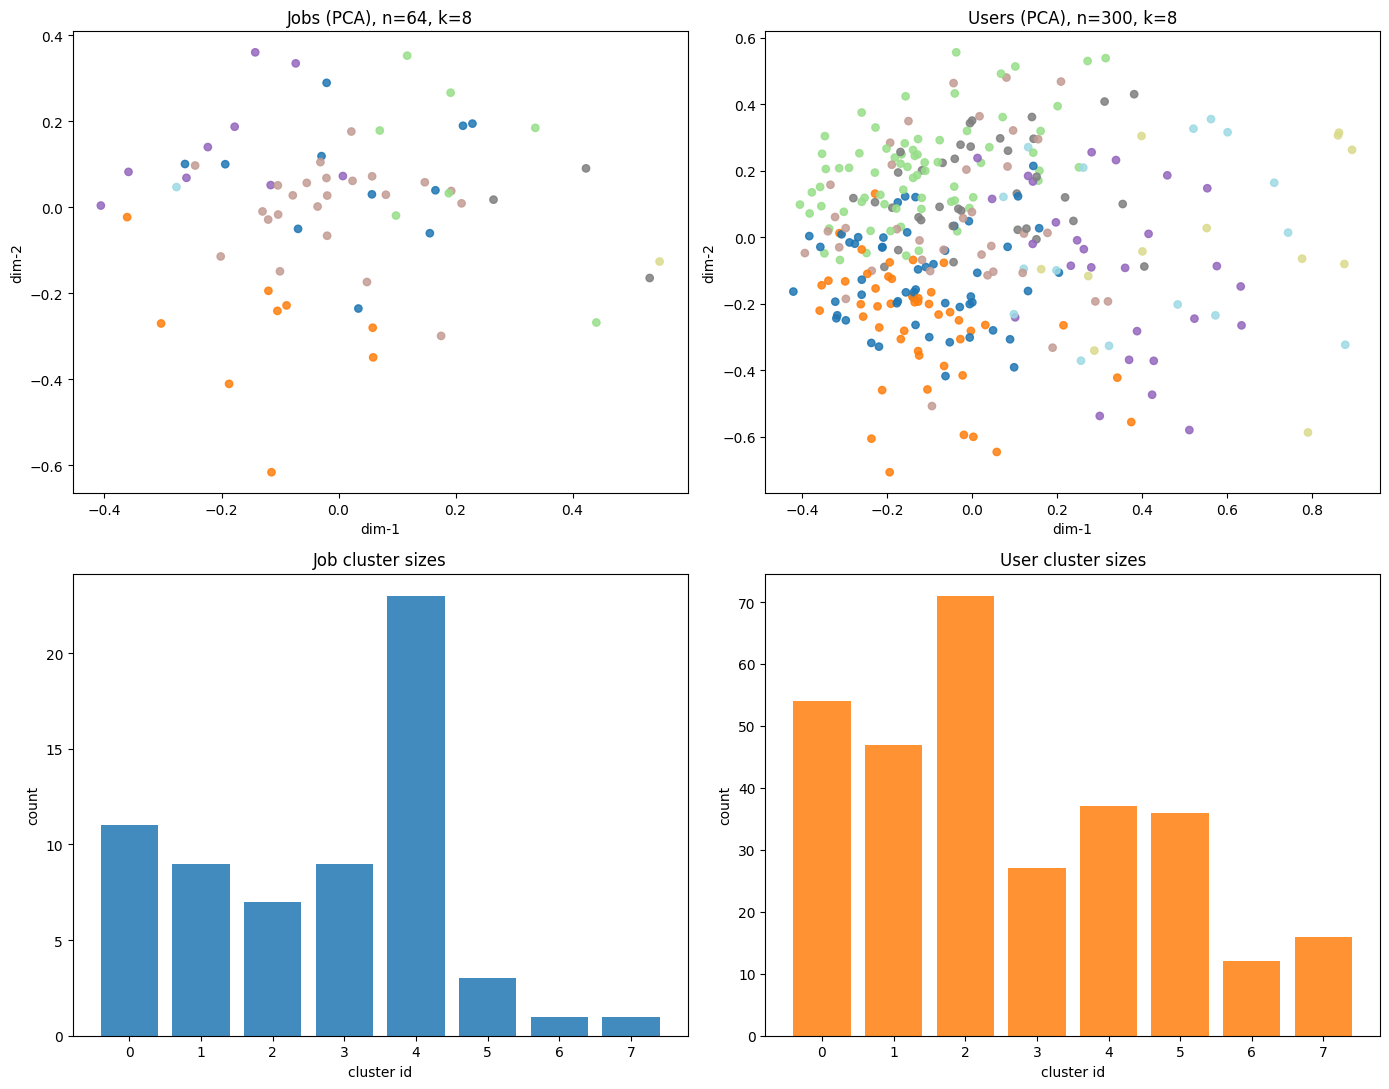

Nearest-neighbor cosine (jobs): mean= 0.8840222954750061 p25= 0.8554363250732422 p75= 0.9327026605606079
Nearest-neighbor cosine (users): mean= 0.779541015625 p25= 0.715599775314331 p75= 0.8587068319320679


In [114]:
# ---------- Better visualizer ----------
import matplotlib.pyplot as plt

def _project_2d(X: np.ndarray, method: str = 'pca') -> np.ndarray:
    method = (method or 'pca').lower()
    if method == 'umap':
        try:
            import umap
            return umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='cosine', random_state=SEED).fit_transform(X)
        except Exception:
            method = 'pca'

    if method == 'pca':
        try:
            from sklearn.decomposition import PCA
            return PCA(n_components=2, random_state=SEED).fit_transform(X)
        except Exception:
            Xc = X - X.mean(axis=0, keepdims=True)
            _, _, vt = np.linalg.svd(Xc, full_matrices=False)
            return Xc @ vt[:2].T

    raise ValueError(f'Unknown projection method: {method}')

def _cluster_labels(X: np.ndarray, k: int) -> np.ndarray:
    k = max(2, min(k, X.shape[0]))
    try:
        from sklearn.cluster import KMeans
        return KMeans(n_clusters=k, n_init=10, random_state=SEED).fit_predict(X)
    except Exception:
        # deterministic fallback labels
        return np.arange(X.shape[0]) % k

def _nearest_neighbor_cosines(X: np.ndarray) -> np.ndarray:
    # X expected approximately unit-normalized.
    S = X @ X.T
    np.fill_diagonal(S, -1.0)
    return S.max(axis=1)

def visualize_clusters(method: str = 'pca', max_points: int = 300, k: int = 8, annotate: bool = False) -> None:
    job_items = list(job_vecs.items())
    user_items = list(user_vecs.items())

    if max_points and max_points > 0:
        if len(job_items) > max_points:
            idx = np.random.choice(len(job_items), size=max_points, replace=False)
            job_items = [job_items[i] for i in idx]
        if len(user_items) > max_points:
            idx = np.random.choice(len(user_items), size=max_points, replace=False)
            user_items = [user_items[i] for i in idx]

    job_ids_local = [k0 for k0, _ in job_items]
    user_ids_local = [k0 for k0, _ in user_items]
    job_X = np.stack([v for _, v in job_items])
    user_X = np.stack([v for _, v in user_items])

    job_xy = _project_2d(job_X, method=method)
    user_xy = _project_2d(user_X, method=method)
    job_labels = _cluster_labels(job_X, k=k)
    user_labels = _cluster_labels(user_X, k=k)

    fig, axes = plt.subplots(2, 2, figsize=(14, 11))

    sc0 = axes[0, 0].scatter(job_xy[:, 0], job_xy[:, 1], c=job_labels, cmap='tab20', s=28, alpha=0.85)
    axes[0, 0].set_title(f'Jobs ({method.upper()}), n={len(job_ids_local)}, k={len(np.unique(job_labels))}')
    axes[0, 0].set_xlabel('dim-1')
    axes[0, 0].set_ylabel('dim-2')

    sc1 = axes[0, 1].scatter(user_xy[:, 0], user_xy[:, 1], c=user_labels, cmap='tab20', s=28, alpha=0.85)
    axes[0, 1].set_title(f'Users ({method.upper()}), n={len(user_ids_local)}, k={len(np.unique(user_labels))}')
    axes[0, 1].set_xlabel('dim-1')
    axes[0, 1].set_ylabel('dim-2')

    if annotate:
        for i, jid in enumerate(job_ids_local):
            axes[0, 0].annotate(jid[:8], (job_xy[i, 0], job_xy[i, 1]), fontsize=6, alpha=0.75)
        for i, uid in enumerate(user_ids_local):
            axes[0, 1].annotate(uid[:8], (user_xy[i, 0], user_xy[i, 1]), fontsize=6, alpha=0.75)

    # Cluster size bars
    job_counts = np.bincount(job_labels)
    user_counts = np.bincount(user_labels)
    axes[1, 0].bar(np.arange(len(job_counts)), job_counts, color='#1f77b4', alpha=0.85)
    axes[1, 0].set_title('Job cluster sizes')
    axes[1, 0].set_xlabel('cluster id')
    axes[1, 0].set_ylabel('count')

    axes[1, 1].bar(np.arange(len(user_counts)), user_counts, color='#ff7f0e', alpha=0.85)
    axes[1, 1].set_title('User cluster sizes')
    axes[1, 1].set_xlabel('cluster id')
    axes[1, 1].set_ylabel('count')

    plt.tight_layout()
    plt.show()

    # Neighbor-cohesion diagnostics
    job_nn = _nearest_neighbor_cosines(job_X)
    user_nn = _nearest_neighbor_cosines(user_X)
    print('Nearest-neighbor cosine (jobs): mean=', float(np.mean(job_nn)), 'p25=', float(np.percentile(job_nn, 25)), 'p75=', float(np.percentile(job_nn, 75)))
    print('Nearest-neighbor cosine (users): mean=', float(np.mean(user_nn)), 'p25=', float(np.percentile(user_nn, 25)), 'p75=', float(np.percentile(user_nn, 75)))

# Example:
visualize_clusters(method='pca', max_points=300, k=8, annotate=False)
# If umap-learn is installed:
# visualize_clusters(method='umap', max_points=300, k=8, annotate=False)


In [120]:
# ---------- Candidate harness ----------
def show_candidate_top_jobs(user_id: str | None = None, top_k: int = 10, bottom_k: int = 10) -> dict:
    """Print one user's profile context and top/bottom closest jobs by vector similarity."""
    if not user_ids:
        raise RuntimeError('No users loaded')

    if user_id is None:
        user_id = random.choice(user_ids)
    if user_id not in users_by_id:
        raise ValueError(f'Unknown user_id: {user_id}')

    user = users_by_id[user_id]
    uvec = user_vecs[user_id]

    scored = []
    for jid in job_ids:
        score = float(np.dot(uvec, job_vecs[jid]))
        scored.append((jid, score))
    scored.sort(key=lambda x: x[1], reverse=True)

    top = scored[:max(1, int(top_k))]
    bottom = list(reversed(scored[-max(1, int(bottom_k)):]))

    print('=== Candidate View ===')
    print('user_id:', user_id)
    print('name:', user.get('name'))
    print('email:', user.get('email'))
    print('objective:', user.get('objective'))
    print('career_objective:', user.get('career_objective'))
    print('\nresume_text:')
    resume = (user.get('resume_text') or '').strip()
    print(resume if resume else '[empty resume_text]')

    top_rows = []
    print(f'\n=== Top {len(top)} Jobs To Apply (by cosine similarity) ===')
    for rank, (jid, score) in enumerate(top, start=1):
        j = jobs_by_id[jid]
        row = {
            'rank': rank,
            'job_id': jid,
            'score': round(score, 4),
            'company_id': j.get('company_id'),
            'title': j.get('title'),
            'location': j.get('location'),
            'skills': j.get('skills'),
            'description_preview': (j.get('description') or '')[:220],
        }
        top_rows.append(row)
        print(f"{rank:2d}. score={row['score']:.4f} | {row['title']} | company_id={row['company_id']} | job_id={jid}")

    bottom_rows = []
    print(f'\n=== Bottom {len(bottom)} Jobs (least similar by cosine) ===')
    for rank, (jid, score) in enumerate(bottom, start=1):
        j = jobs_by_id[jid]
        row = {
            'rank': rank,
            'job_id': jid,
            'score': round(score, 4),
            'company_id': j.get('company_id'),
            'title': j.get('title'),
            'location': j.get('location'),
            'skills': j.get('skills'),
            'description_preview': (j.get('description') or '')[:220],
        }
        bottom_rows.append(row)
        print(f"{rank:2d}. score={row['score']:.4f} | {row['title']} | company_id={row['company_id']} | job_id={jid}")

    return {'user_id': user_id, 'top_jobs': top_rows, 'bottom_jobs': bottom_rows}

# Example usage:
# candidate_result = show_candidate_top_jobs()
# candidate_result = show_candidate_top_jobs(user_id = random.choice(user_ids), top_k=10, bottom_k=10)
candidate_result = show_candidate_top_jobs(user_id = random.choice(user_ids), top_k=10, bottom_k=10)


=== Candidate View ===
user_id: 4504998a-ffca-4a62-a7ab-90b2346c0723
name: Christopher Ojo
email: christopherojo@gmail.com
objective: None
career_objective: Data scientist solving complex business problems

resume_text:
Christopher Ojo
416-475-5656 | cojo@uwo.ca | linkedin.com/in/christopher-ojo | github.com/christopherojo
Education
University of Western Ontario
Sep 2020 - Oct 2026
Bachelor of Engineering Science (BESc) in Software Engineering
GPA: 4.0/4.0
University of Western Ontario - Richard Ivey School of Business
Sep 2020 - Oct 2026
Bachelor of Arts (BA) in Honors Business Administration (HBA)
GPA: 3.7/4.0
Awards: RBC Scholarship in Engineering ($25,000), Top 3 in Western’s ICPC Qualifier, Dean’s Honor List.
Relevant Courses: Finance (TA), Machine Learning with R, Applied Probability & Stats, Operating Systems.
Technical Skills
Languages: Java, Python, C/C++, R, SQL, NoSQL, JavaScript, Bash, HTML, Tailwind, SASS, CSS
Frameworks/Tools: React, Node.js, Flask, JUnit, Git, Docker, Go